# Imports and Defines

## Imports
    Imports all modules and submodules that were necessary in this study.
    Special mention to TimeSeriesCrossValidation which was created with the purpose to be used in this thesis.

In [2]:
import numpy as np
import pandas as pd
import xlsxwriter
import warnings
import matplotlib.pyplot as plt
import pandas_datareader as dr
import seaborn as sns

from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import LSTM, SimpleRNN
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import load_model

# This python module was developed for this thesis
from TimeSeriesCrossValidation import splitTrain, splitTrainVal, splitTrainValTest

%matplotlib inline

## Define Functions
    Defines helper functions

In [3]:
# Compute MAE over an array of different horizons
def horizonMAE(y_true, y_pred, horizonSteps):
    ae  = abs(y_pred - y_true);
    list_MAE = list()
    for i in horizonSteps:
        list_MAE.append(round(np.mean(ae[:i]), 2))
    return list_MAE;

In [4]:
# Define Mean Absolute Percentage Error
def absolute_percentage_error(y_true, y_pred):
    if (len(y_true[y_true == 0])):
        print("Division by zero!")
        return None;
    else:
        return 100*(abs((y_pred - y_true) / y_true));

In [5]:
# Compute MAPE over an array of different horizons
def horizonMAPE(y_true, y_pred, horizonSteps):
    ape = absolute_percentage_error(y_true, y_pred);
    if ape is not None:
        list_MAPE = list()
        for i in horizonSteps:
            list_MAPE.append(round(np.mean(ape[:i]), 2))
        return list_MAPE;

In [6]:
# Revert diffLogSeries values to real scale values using initialValue (Diff(Log(x)) -> x)
def revertLogDiff(initialValue, diffLogSeries):
    original = initialValue
    #for i in np.arange(len(diffLogSeries)):
    #    original = np.append(original, original[-1]*(np.e**diffLogSeries[i]))
    for diffLogVal in diffLogSeries:
        original = np.append(original, original[-1]*(np.e**diffLogVal))
    return original[1:]

## Define Univariate Time-Series to study
    df: Dataframe with an index and a value column
    title: Title of data being used
    xlab: Label of df.index
    ylab: Label of df.values
    seasonal_periods: The repetition cycle
    
    stepsToForecast: Steps to forecast out-of-sample (and in-sample)

In [7]:
stepsToForecast = [1, 3, 12];
df = dr.DataReader('CPIAUCSL', "fred", start='1947-01-01', end='2019-09-01')
df_train = df[['CPIAUCSL']][:-stepsToForecast[-1]].rename(columns={'CPIAUCSL': 'train'})
df_test = df[['CPIAUCSL']][-stepsToForecast[-1]:].rename(columns={'CPIAUCSL': 'test'})
title = 'CPIAUC'
xlab = 'Months/Year'; 
ylab = 'Consumer Price Index';
seasonal_periods = 12

#stepsToForecast = [1, 5, 21];
#df = pd.read_csv("PSI_20_Data_1992_Stooq.csv") 
#df = pd.DataFrame(df, columns= ['Date','Close'])
#df.set_index('Date', drop=True, inplace=True)
#df.index = pd.DatetimeIndex(df.index)
#df = df.truncate(after='2019-09-28')
#df_train = df[['Close']][:-stepsToForecast[-1]].rename(columns={'Close': 'train'})
#df_test = df[['Close']][-stepsToForecast[-1]:].rename(columns={'Close': 'test'})
#title = 'PSI20: Historical Closing Prices'
#xlab = 'Business Days/Year'; 
#ylab = 'Closing Price (Euro)';
#seasonal_periods = 5

#stepsToForecast = [1, 5, 21];
#df = dr.data.get_data_yahoo('SPY', start= '1993-01-01', end='2019-09-27')
#df_train = df[['Close']][:-stepsToForecast[-1]].rename(columns={'Close': 'train'})
#df_test = df[['Close']][-stepsToForecast[-1]:].rename(columns={'Close': 'test'})
#title = 'SP500'
#xlab = 'Business Days/Year'; 
#ylab = 'Closing Price (Dollar)';
#seasonal_periods=5;

#stepsToForecast = [1, 3, 12];
#df = dr.DataReader("TRFVOLUSM227NFWA", "fred", start="1947-01-01", end="2019-09-01")
#df_train = df[['TRFVOLUSM227NFWA']][:-stepsToForecast[-1]].rename(columns={'TRFVOLUSM227NFWA': 'train'})
#df_test = df[['TRFVOLUSM227NFWA']][-stepsToForecast[-1]:].rename(columns={'TRFVOLUSM227NFWA': 'test'})
#title = "Vehicle Miles Traveled";
#xlab = "Months/Year";
#ylab = "Millions of Miles";
#seasonal_periods = 12

# Training Deep Neural Network

## Data Pre-Processing
    The options here include:
        - Slicing the data
        - Standardization or Normalization
        - Smoothing techniques
        - Stationarity techniques
        - Working with residuals

In [8]:
# Allows training data to be sliced
series_input = df_train.values[-20*12:].copy()
#series_input = df_train.values.copy()

# Smoothing
# gamma = 0.3
# ExpMA = 0.0 
# for i in range(series_input.size):
#    ExpMA = gamma*series_input[i] + (1-gamma)*ExpMA
#    series_input[i] = ExpMA

# Select between 'None', Normalization', 'Standardization', 'DiffLog'
PreProcessing_str = 'Filipocas'

if (PreProcessing_str == 'Normalization'):
    scaler = MinMaxScaler()
    series_input = scaler.fit_transform(series_input)
elif (PreProcessing_str == 'Standardization'):
    scaler = StandardScaler()
    series_input = scaler.fit_transform(series_input)
elif (PreProcessing_str == 'DiffLog'):
    series_input_bd = series_input # before diff
    series_input = np.log(pd.DataFrame(series_input)).diff().dropna().values

## Visualization of Data Pre-Processed

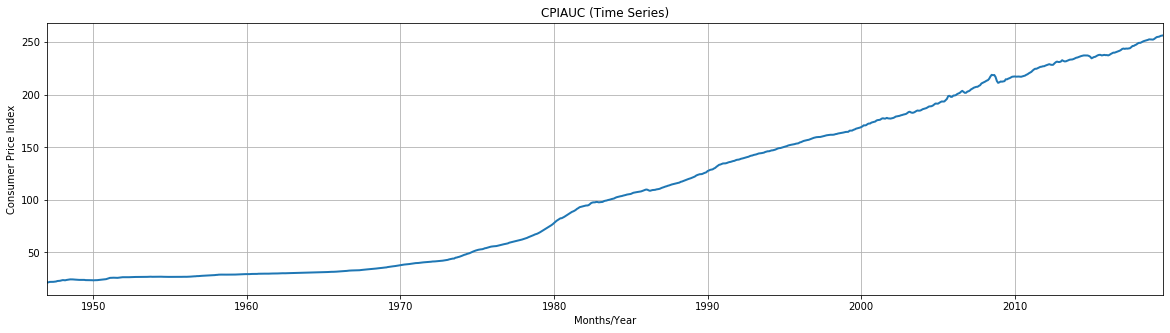

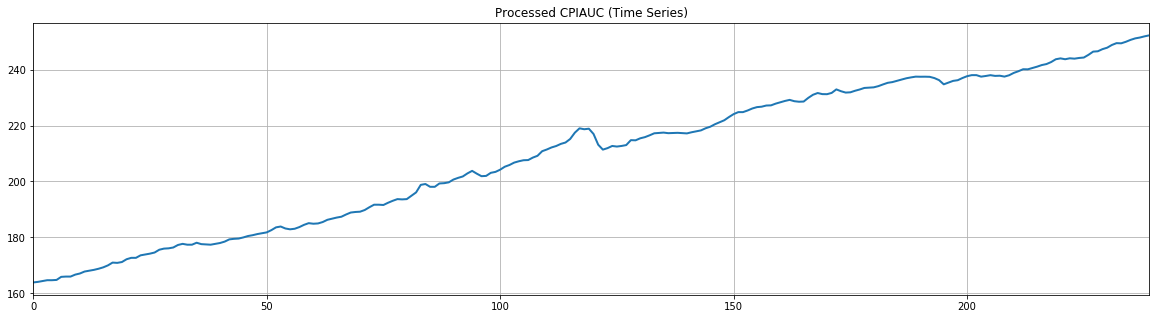

In [11]:
plt.figure(figsize=(20,5))
plt.plot(df.index, df.values, LineWidth=2)
plt.title(title + ' (Time Series)')
plt.xlabel(xlab)
plt.ylabel(ylab)
plt.xlim([df.index[0], df.index[-1]])
plt.grid()

plt.figure(figsize=(20,5))
plt.plot(series_input, LineWidth=2)
plt.title('Processed ' + title + ' (Time Series)')
plt.grid()
plt.xlim(0, len(series_input)-1)
plt.show()

## Model Selection (tune hyper-parameters)
    In this work, the models to be used will be:
        - Multilayer Perceptron (MLP)
        - Recurrent Neural Network (RNN)
        - Long Short-Term Memory (LSTM)
        
    Where the tunable hyper-parameters are:
        Explicit:
            - n_steps_input: Number of samples to be fed to the ANN
            - n_steps_jump: Number of samples to jump in training (speed up technique)
            - train_epochs: Number of epochs for the model to train
        Implicit:
            - Number of layers
            - Number of neurons of EACH layer
            - Activation function of EACH layer
            - Dropout
            - Optimization algorithm and loss function used in training
        
    Note: n_steps_forecast is chosen a-priori.

In [8]:
# Select between 'MLP', 'RNN', or 'LSTM'
NN_str = 'MLP'

n_steps_input = 50
n_steps_jump = 1

train_epochs = 300

model = Sequential()
if (NN_str == 'MLP'):
    model.add(Dense(50, activation='relu', input_dim=n_steps_input))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(80, activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(stepsToForecast[-1], activation='linear'))
elif (NN_str == 'RNN'):
    model.add(SimpleRNN(100, input_shape=(n_steps_input, 1), activation='linear', return_sequences=True))    
    model.add(SimpleRNN(50, activation='linear', return_sequences=True)) 
    model.add(SimpleRNN(25, activation='linear', return_sequences=False))
    model.add(Dense(stepsToForecast[-1], activation='linear'))
elif (NN_str == 'LSTM'):
    model.add(LSTM(10,input_shape=(n_steps_input, 1), activation='linear', return_sequences=True))  
    model.add(LSTM(25, activation='linear', return_sequences=True))
    model.add(LSTM(50, activation='linear', return_sequences=True))
    model.add(LSTM(30, activation='linear', return_sequences=True))
    model.add(LSTM(20, activation='linear', return_sequences=True))
    model.add(LSTM(15, activation='linear', return_sequences=False))
    model.add(Dense(stepsToForecast[-1], activation='linear'))
else:
    print("This model is not recognized.")

model.compile(optimizer='adam', loss='mae')

## Cross-Validation
    Select one of the following cross-validation methods:
        - Forward Chaining
    .split_train_val_test_forwardChaining(series_input, n_steps_input, stepsToForecast[-1], n_steps_jump) 
        - K-Fold
    .split_train_val_test_kFold(series_input, n_steps_input, stepsToForecast[-1], n_steps_jump)
        - Group K-Fold
    .split_train_val_test_groupKFold(series_input, n_steps_input, stepsToForecast[-1], n_steps_jump)
        
    Note: More info at https://github.com/DidierRLopes/TimeSeriesCrossValidation

### Compute Cross-Validation Errors

In [9]:
# splitValTest = True considers [Train, Val, Test]
# splitValTest = False considers [Train, Val&Test]
splitValTest = False
# Select between 'ForwardChaining', 'KFold', or 'GroupKFold'
CV_str = 'ForwardChaining'

if (splitValTest):
    if (CV_str == 'ForwardChaining'):
        X_train, y_train, X_cv, y_cv, X_test, y_test = splitTrainValTest \
            .split_train_val_test_forwardChaining(series_input, n_steps_input, stepsToForecast[-1], n_steps_jump)
    elif (CV_str == 'KFold'):
        X_train, y_train, X_cv, y_cv, X_test, y_test = splitTrainValTest \
            .split_train_val_test_kFold(series_input, n_steps_input, stepsToForecast[-1], n_steps_jump)
    elif (CV_str == 'GroupKFold'):
        X_train, y_train, X_cv, y_cv, X_test, y_test = splitTrainValTest \
            .split_train_val_test_groupKFold(series_input, n_steps_input, stepsToForecast[-1], n_steps_jump)
    else:
        print("This model Cross-Validation technique is not recognized.")

    if (PreProcessing_str == 'DiffLog'):
        if (CV_str == 'ForwardChaining'):
            X_train_bd, y_train_bd, X_cv_bd, y_cv_bd, X_test_bd, y_test_bd = splitTrainValTest \
                .split_train_val_test_forwardChaining(series_input_bd, n_steps_input, stepsToForecast[-1], n_steps_jump)
        elif (CV_str == 'KFold'):
            X_train_bd, y_train_bd, X_cv_bd, y_cv_bd, X_test_bd, y_test_bd = splitTrainValTest \
                .split_train_val_test_kFold(series_input_bd, n_steps_input, stepsToForecast[-1], n_steps_jump)
        elif (CV_str == 'GroupKFold'):
            X_train_bd, y_train_bd, X_cv_bd, y_cv_bd, X_test_bd, y_test_bd = splitTrainValTest \
                .split_train_val_test_groupKFold(series_input_bd, n_steps_input, stepsToForecast[-1], n_steps_jump)
        else:
            print("This model Cross-Validation technique is not recognized.")
else:
    if (CV_str == 'ForwardChaining'):
        X_train, y_train, X_cv, y_cv = splitTrainVal \
            .split_train_val_forwardChaining(series_input, n_steps_input, stepsToForecast[-1], n_steps_jump)
    elif (CV_str == 'KFold'):
        X_train, y_train, X_cv, y_cv = splitTrainVal \
            .split_train_val_kFold(series_input, n_steps_input, stepsToForecast[-1], n_steps_jump)
    elif (CV_str == 'GroupKFold'):
        X_train, y_train, X_cv, y_cv = splitTrainVal \
            .split_train_val_groupKFold(series_input, n_steps_input, stepsToForecast[-1], n_steps_jump)
    else:
        print("This model Cross-Validation technique is not recognized.")


    if (PreProcessing_str == 'DiffLog'):
        if (CV_str == 'ForwardChaining'):
            X_train_bd, y_train_bd, X_cv_bd, y_cv_bd = splitTrainVal \
                .split_train_val_forwardChaining(series_input_bd, n_steps_input, stepsToForecast[-1], n_steps_jump)
        elif (CV_str == 'KFold'):
            X_train_bd, y_train_bd, X_cv_bd, y_cv_bd = splitTrainVal \
                .split_train_val_kFold(series_input_bd, n_steps_input, stepsToForecast[-1], n_steps_jump)
        elif (CV_str == 'GroupKFold'):
            X_train_bd, y_train_bd, X_cv_bd, y_cv_bd = splitTrainVal \
                .split_train_val_groupKFold(series_input_bd, n_steps_input, stepsToForecast[-1], n_steps_jump)
        else:
            print("This model Cross-Validation technique is not recognized.")
    
dict_mae = {} 
for ix in np.arange(len(X_train)):
    
    print("%d/%d" % (ix+1, len(X_train)));
    
    if (NN_str == 'MLP'):
        X_train[ix] = np.squeeze(X_train[ix], axis=2)
        X_cv[ix] = np.squeeze(X_cv[ix], axis=2)
        if (splitValTest):
            X_test[ix] = np.squeeze(X_test[ix], axis=2)
        if (PreProcessing_str == 'DiffLog'):
            X_train_bd[ix] = np.squeeze(X_train_bd[ix], axis=2)
            X_cv_bd[ix] = np.squeeze(X_cv_bd[ix], axis=2)
            if (splitValTest):
                X_test_bd[ix] = np.squeeze(X_test_bd[ix], axis=2)
    y_train[ix] = np.squeeze(y_train[ix], axis=2)
    y_cv[ix] = np.squeeze(y_cv[ix], axis=2)
    if (splitValTest):
        y_test[ix] = np.squeeze(y_test[ix], axis=2)
    if (PreProcessing_str == 'DiffLog'):
            y_train_bd[ix] = np.squeeze(y_train_bd[ix], axis=2)
            y_cv_bd[ix] = np.squeeze(y_cv_bd[ix], axis=2)
            if (splitValTest):
                y_test_bd[ix] = np.squeeze(y_test_bd[ix], axis=2)
    
    ## ------- TRAINING MODEL -------
    model.fit(X_train[ix], y_train[ix], epochs = train_epochs, verbose = 0);
    
    ## ------- TRAINING ERROR -------
    if (PreProcessing_str in ['Normalization', 'Standardization']): 
        y_pred_train_t = scaler.inverse_transform(model.predict(X_train[ix]))
        y_train_t = scaler.inverse_transform(y_train[ix])
    elif (PreProcessing_str == 'DiffLog'):
        y_pred_train_t = list()
        y_train_t = list()
        for i in np.arange(len(X_train[ix])):
            if (NN_str == 'LSTM'):
                y_pred_train_t.append(revertLogDiff(np.array([X_train_bd[ix][i][-1]]), \
                    np.array(model.predict(X_train[ix][i].reshape(1, n_steps_input, 1))).tolist()[0]))
            else:
                y_pred_train_t.append(revertLogDiff(np.array([X_train_bd[ix][i][-1]]), \
                        np.array(model.predict(X_train[ix][i].reshape(1, n_steps_input))).tolist()[0]))
            y_train_t.append(revertLogDiff(np.array([y_train_bd[ix][i][0]]), y_train[ix][i]))
    else:
        y_pred_train_t = model.predict(X_train[ix])
        y_train_t = y_train[ix]
        
    list_mae_train = list()
    for i in np.arange(len(y_train_t)):
        if (PreProcessing_str == 'DiffLog'):
            mae_train = mean_absolute_error(y_train_t[i], y_pred_train_t[i])
        else:
            mae_train = mean_absolute_error(y_train_t[i,:], y_pred_train_t[i,:])
        list_mae_train.append(mae_train)
        
    ## ------- CROSS VALIDATION ERROR -------
    if (PreProcessing_str in ['Normalization', 'Standardization']): 
        y_pred_cv_t = scaler.inverse_transform(model.predict(X_cv[ix]))
        y_cv_t = scaler.inverse_transform(y_cv[ix])
    elif (PreProcessing_str == 'DiffLog'):
        y_pred_cv_t = list()
        y_cv_t = list()
        for i in np.arange(len(X_cv[ix])):
            if (NN_str == 'LSTM'):
                y_pred_cv_t.append(revertLogDiff(np.array([X_cv_bd[ix][i][-1]]), \
                        np.array(model.predict(X_cv[ix][i].reshape(1, n_steps_input, 1))).tolist()[0]))
            else:
                y_pred_cv_t.append(revertLogDiff(np.array([X_cv_bd[ix][i][-1]]), \
                        np.array(model.predict(X_cv[ix][i].reshape(1, n_steps_input))).tolist()[0]))
            y_cv_t.append(revertLogDiff(np.array([y_cv_bd[ix][i][0]]), y_cv[ix][i]))
    else:
        y_pred_cv_t = model.predict(X_cv[ix])
        y_cv_t = y_cv[ix]

    list_mae_cv = list()
    for i in np.arange(len(y_cv_t)):
        if (PreProcessing_str == 'DiffLog'):
            mae_cv = mean_absolute_error(y_cv_t[i], y_pred_cv_t[i])
        else:
            mae_cv = mean_absolute_error(y_cv_t[i,:], y_pred_cv_t[i,:])
        list_mae_cv.append(mae_cv)

    if (splitValTest):
        ## ------- TEST ERROR -------
        if (PreProcessing_str in ['Normalization', 'Standardization']): 
            y_pred_test_t = scaler.inverse_transform(model.predict(X_test[ix]))
            y_test_t = scaler.inverse_transform(y_test[ix])
        elif (PreProcessing_str == 'DiffLog'):
            y_pred_test_t = list()
            y_test_t = list()
            for i in np.arange(len(X_test[ix])):
                if (NN_str == 'LSTM'):
                    y_pred_test_t.append(revertLogDiff(np.array([X_test_bd[ix][i][-1]]), \
                            np.array(model.predict(X_test[ix][i].reshape(1, n_steps_input, 1))).tolist()[0]))
                else:
                    y_pred_test_t.append(revertLogDiff(np.array([X_test_bd[ix][i][-1]]), \
                            np.array(model.predict(X_test[ix][i].reshape(1, n_steps_input))).tolist()[0]))
                y_test_t.append(revertLogDiff(np.array([y_test_bd[ix][i][0]]), y_test[ix][i]))
        else:
            y_pred_test_t = model.predict(X_test[ix])
            y_test_t = y_test[ix]

        list_mae_test = list()
        for i in np.arange(len(y_test_t)):   
            if (PreProcessing_str == 'DiffLog'):
                mae_test = mean_absolute_error(y_test_t[i], y_pred_test_t[i])
            else:
                mae_test = mean_absolute_error(y_test_t[i,:], y_pred_test_t[i,:])
            list_mae_test.append(mae_test)
    
        dict_mae[str(ix)] = {'train': list_mae_train, 'cv': list_mae_cv, 'test': list_mae_test}
    else:
        dict_mae[str(ix)] = {'train': list_mae_train, 'cv': list_mae_cv}
    
trainMae = np.mean([np.mean(dict_mae[str(runIx)]['train']) for runIx in np.arange(len(X_train))]);
cvMae = np.mean([np.mean(dict_mae[str(runIx)]['cv']) for runIx in np.arange(len(X_train))]);
if (splitValTest):
    testMae = np.mean([np.mean(dict_mae[str(runIx)]['test']) for runIx in np.arange(len(X_train))]);

1/128
2/128
3/128
4/128
5/128
6/128
7/128
8/128
9/128
10/128
11/128
12/128
13/128
14/128
15/128
16/128
17/128
18/128
19/128
20/128
21/128
22/128
23/128
24/128
25/128
26/128
27/128
28/128
29/128
30/128
31/128
32/128
33/128
34/128
35/128
36/128
37/128
38/128
39/128
40/128
41/128
42/128
43/128
44/128
45/128
46/128
47/128
48/128
49/128
50/128
51/128
52/128
53/128
54/128
55/128
56/128
57/128
58/128
59/128
60/128
61/128
62/128
63/128
64/128
65/128
66/128
67/128
68/128
69/128
70/128
71/128
72/128
73/128
74/128
75/128
76/128
77/128
78/128
79/128
80/128
81/128
82/128
83/128
84/128
85/128
86/128
87/128
88/128
89/128
90/128
91/128
92/128
93/128
94/128
95/128
96/128
97/128
98/128
99/128
100/128
101/128
102/128
103/128
104/128
105/128
106/128
107/128
108/128
109/128
110/128
111/128
112/128
113/128
114/128
115/128
116/128
117/128
118/128
119/128
120/128
121/128
122/128
123/128
124/128
125/128
126/128
127/128
128/128


### Cross-Validation Performance
    Assess Training / Cross-Validation / Test
    DEBUG_LEVEL = 0 - Only shows STATS of ALL runs
                  1 - Shows the average MAE through runs 
                  2 - Shows the MAE at each run at each train/cv/test set    

In [10]:
DEBUG_LEVEL = 0

print("STATS of ALL runs")    
print("Train avg MAE avg = %.4f" % trainMae) 
print("Cross-Validation avg MAE avg = %.4f" % cvMae)
if (splitValTest):
    print("Test avg MAE avg = %.4f" % testMae)

list_train_mae = list()
list_cv_mae = list()
if (splitValTest):
    list_test_mae = list()
for runIx in np.arange(len(X_train)):
    if (DEBUG_LEVEL > 0):
        print("")
        print("----- RUN NUMBER %d -----" % (runIx+1))

    list_train_mae.append(np.mean(dict_mae[str(runIx)]['train']))
    if (DEBUG_LEVEL > 0):
        print ("Train MAE avg = %.3f" % np.mean(dict_mae[str(runIx)]['train'])) 
        if (DEBUG_LEVEL > 1):
            if (len(dict_mae[str(runIx)]['train'])>1):
                print("Individual trains: " + str([round(x,4) for x in dict_mae[str(runIx)]['train']]))
    
    list_cv_mae.append(np.mean(dict_mae[str(runIx)]['cv']))
    if (DEBUG_LEVEL > 0):
        print ("Cross-Validation MAE avg = %.3f" % np.mean(dict_mae[str(runIx)]['cv'])) 
        if (DEBUG_LEVEL > 1):
            if (len(dict_mae[str(runIx)]['cv'])>1):
                print("Individual cross-validations: " + str([round(x,4) for x in dict_mae[str(runIx)]['cv']]))
    
    if (splitValTest):
        list_test_mae.append(np.mean(dict_mae[str(runIx)]['test']))
        if (DEBUG_LEVEL > 0):
            print ("Test MAE avg = %.3f" % np.mean(dict_mae[str(runIx)]['test'])) 
            if (DEBUG_LEVEL > 1):
                if (len(dict_mae[str(runIx)]['test'])>1):
                    print("Individual tests: " + str([round(x,4) for x in dict_mae[str(runIx)]['test']]))

STATS of ALL runs
Train avg MAE avg = 1.5600
Cross-Validation avg MAE avg = 4.0053


### Cross-Validation Plot

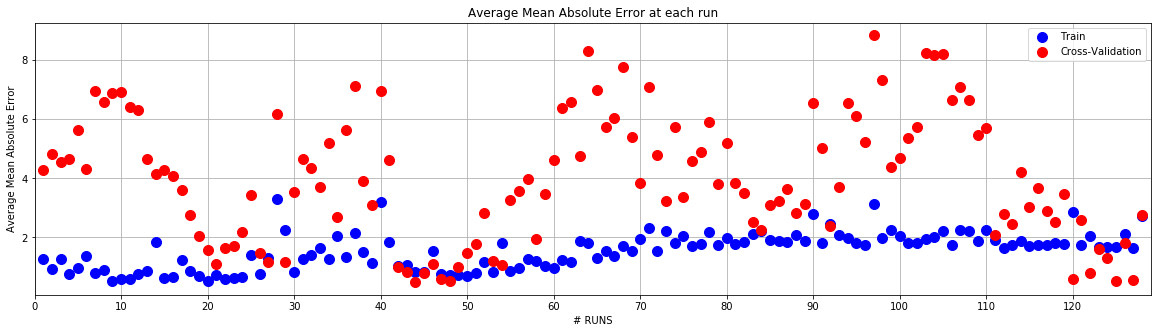

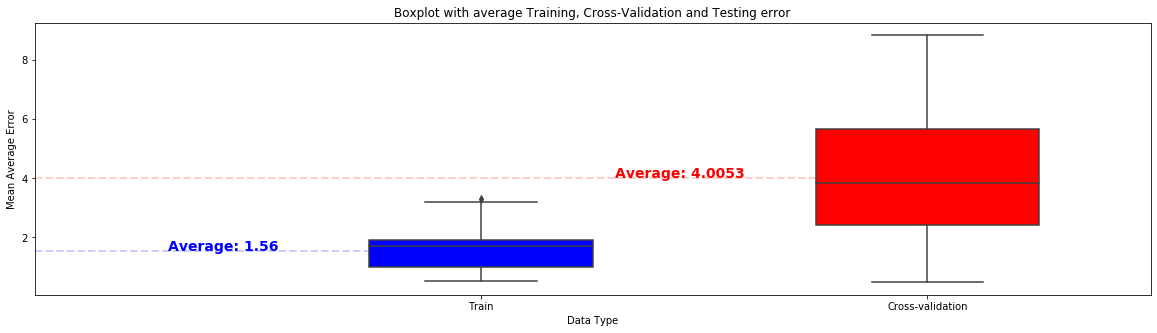

In [11]:
# Plot Mean Absolute Errors of each run
plt.figure(figsize=(20,5))
plt.plot(np.arange(len(X_train))+1, list_train_mae, 'bo', markersize=10, label = 'Train')
plt.plot(np.arange(len(X_train))+1, list_cv_mae, 'ro', markersize=10, label = 'Cross-Validation')
if (splitValTest):
    plt.plot(np.arange(len(X_train))+1, list_test_mae, 'go', markersize=10, label = 'Test')
plt.legend()
plt.xlabel('# RUNS')
plt.ylabel('Average Mean Absolute Error')
plt.title('Average Mean Absolute Error at each run')
if (len(X_train) > 500):
    plt.xticks(np.arange(0, len(X_train), 100))
if (len(X_train) > 250):
    plt.xticks(np.arange(0, len(X_train), 50))
elif (len(X_train) > 50):
    plt.xticks(np.arange(0, len(X_train), 10))
else:
    plt.xticks(np.arange(1,len(X_train)+1))
plt.xlim([0, len(X_train)+1])
plt.grid()

if (splitValTest):
    # Plot Mean Absolute Errors of each run
    x_bp = np.concatenate((np.repeat('Train', len(list_train_mae)), \
                           np.repeat('Cross-validation', len(list_cv_mae)), 
                           np.repeat('Test', len(list_test_mae))), axis = 0)

    y_bp = np.concatenate((list_train_mae, list_cv_mae, list_test_mae), axis = 0)
else:
    # Plot Mean Absolute Errors of each run
    x_bp = np.concatenate((np.repeat('Train', len(list_train_mae)), \
                           np.repeat('Cross-validation', len(list_cv_mae))), axis = 0)
    y_bp = np.concatenate((list_train_mae, list_cv_mae), axis = 0)

    
df_bp = pd.DataFrame(data={'Data Type': x_bp, 'Mean Average Error': y_bp})

plt.figure(figsize=(20, 5))
bplot=sns.boxplot(y='Mean Average Error', x='Data Type', data=df_bp, width=0.5)
bplot.artists[0].set_facecolor('blue')
bplot.artists[1].set_facecolor('red')
plt.title('Boxplot with average Training, Cross-Validation and Testing error');
plt.plot([-1,0], [trainMae, trainMae],'b--', lw=2, alpha=0.2)
plt.plot([-1,1], [cvMae, cvMae],'r--', lw=2, alpha=0.2)
if (splitValTest):
    bplot.artists[2].set_facecolor('green')
    plt.plot([-1,2], [testMae, testMae],'g--', lw=2, alpha=0.2)
    plt.xlim([-1, 2.5])
    plt.text(1.30, 1*testMae, 'Average: ' + str(round(testMae,4)), fontsize=14, color='g', fontweight='bold')
else:
    plt.xlim([-1, 1.5])
plt.text(-0.70, 1*trainMae, 'Average: ' + str(round(trainMae,4)), fontsize=14, color='b', fontweight='bold')
plt.text(0.30, 1*cvMae, 'Average: ' + str(round(cvMae,4)), fontsize=14, color='r', fontweight='bold')

plt.show()

# Model forecasting

### Perform statistics on predictions
    This aims to run several predictions in order to have a stronger argument on predictions performance
    MAX_ITER corresponds to the amount of training & prediction used for statistics

In [12]:
MAX_ITER = 4

# This uses the entire training set to train
Xtest, ytest = splitTrain.split_train(series_input, n_steps_input, stepsToForecast[-1], n_steps_jump)

if (NN_str == 'MLP'):
    Xtest = np.squeeze(Xtest, axis=2)
ytest = np.squeeze(ytest, axis=2)

real_array = np.array(df_test.values).flatten()

i = 0
list_pred = list()
while (i < MAX_ITER):
    
    print("%d/%d" % (i+1, MAX_ITER));
    
    ## ------- TRAIN MODEL WITH ALL DATA-------
    model.fit(Xtest, ytest, epochs = train_epochs, verbose = 0);

    if (NN_str == 'MLP'):
        yhat = model.predict(series_input[-n_steps_input:].T, verbose=0)
        yhat_inSample = model.predict(series_input[-n_steps_input-stepsToForecast[-1]:-stepsToForecast[-1]].T, verbose=0)
    else:
        yhat = model.predict(series_input[-n_steps_input:].reshape(1, n_steps_input, 1), verbose=0)
        yhat_inSample = model.predict(series_input[-n_steps_input-stepsToForecast[-1]:-stepsToForecast[-1]].reshape(1, n_steps_input, 1), verbose=0)

    y_pred_test = yhat.tolist()
    y_pred_inSample = yhat_inSample.tolist()

    if (PreProcessing_str in ['Normalization', 'Standardization']): 
        y_pred_test_t = scaler.inverse_transform(y_pred_test)
        y_pred_inSample_t = scaler.inverse_transform(y_pred_inSample)
    elif (PreProcessing_str == 'DiffLog'):
        y_pred_test_t = revertLogDiff(df_train.values[-1], y_pred_test[0])
        y_pred_inSample_t = revertLogDiff(df_train.values[-stepsToForecast[-1]-1], y_pred_inSample[0])
    else:
        y_pred_test_t = y_pred_test
        y_pred_inSample_t = y_pred_inSample

    predictions_array = np.array(y_pred_test_t).flatten()
    predictions_inSample_array = np.array(y_pred_inSample_t).flatten()
    
    i = i + 1
    mae = horizonMAE(real_array, predictions_array, stepsToForecast)
    mape = horizonMAPE(real_array, predictions_array, stepsToForecast)
    list_pred.append((mae, mape, predictions_array, predictions_inSample_array))

1/4
2/4
3/4
4/4


###  Statistics cleaning
    This aims to extract the performance of our NN. For that we need to select PRED_OUTL and the forecast horizon that we are predicting for stepsToForecast(PRED_IX)
    PRED_OUTL corresponds to the number of predictions that are considered outliers
    PRED_IX corresponds to the number steps to forecast you want to organize your data

    Note that:
        - PRED_OUTL < MAX_ITER, with both being even numbers
        - The percentage considered as outlier is given by 100*(PRED_OUTL/MAX_ITER)
        - 1 < PRED_IX < len(stepsToForecast)

In [42]:
PRED_IX = 3
PRED_OUTL = 3

# Sorts elements based on longer term horizon
list_pred.sort(key=lambda elem: elem[0][PRED_IX-1])

if (PRED_OUTL % 2) != 0:
    PRED_OUTL = PRED_OUTL + 1
    
if (PRED_OUTL >= len(list_pred)):
    print("You cannot consider all the runs as outliers. No outliers will be considered")
    PRED_OUTL = 0

if (PRED_OUTL == 0):
    list_pred_outlRemoved = list_pred
else:
    list_pred_outlRemoved = list_pred[int(PRED_OUTL/2):-int(PRED_OUTL/2)]

print('The MAE(MAPE) with a horizon of ' + str(stepsToForecast[PRED_IX-1]) + ' samples for ' \
      + str(round(100-100*(PRED_OUTL/MAX_ITER),2)) + '% (' \
      + str(MAX_ITER-PRED_OUTL) + '\\' + str(MAX_ITER) + ') of runs is: \t'
      + str(list_pred_outlRemoved[0][0][PRED_IX-1]) + ' (' \
      + str(list_pred_outlRemoved[0][1][PRED_IX-1]) + '%) and ' \
      + str(list_pred_outlRemoved[-1][0][PRED_IX-1]) + ' (' \
      + str(list_pred_outlRemoved[-1][1][PRED_IX-1]) + '%)')

You cannot consider all the runs as outliers. No outliers will be considered
The MAE(MAPE) with a horizon of 12 samples for 100.0% (4\4) of runs is: 	0.41 (0.16%) and 1.55 (0.61%)


### Plot Prediction
    This will show the plot of, within the specified confidence interval, that perform the best prediction based on the horizon samples chosen (using PRED_IX above)
    This allows to understand what happens throughout the horizon forecast

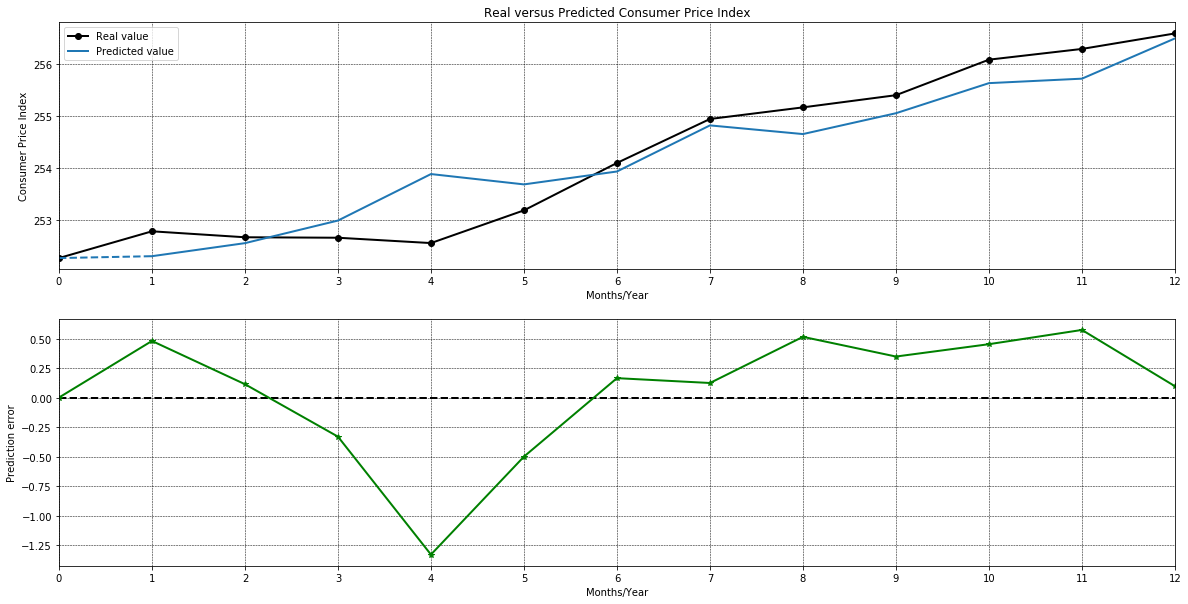

Prediction for 1 Months/Year: MAE = 0.48 (0.19%)
Prediction for 3 Months/Year: MAE = 0.31 (0.12%)
Prediction for 12 Months/Year: MAE = 0.42 (0.16%)


In [14]:
cmap = plt.get_cmap("tab10")

plt.figure(figsize=(20,10))
plt.subplot(211)
plt.title('Real versus Predicted ' + ylab) 
plt.plot(range(0,len(real_array)+1), np.concatenate((df_train.values[-1], real_array), axis=0), 'k-o', linewidth=2)
plt.plot(range(1,len(predictions_array)+1), list_pred_outlRemoved[0][2], color = cmap(0), linewidth=2)
plt.plot([0,1], [df_train.values[-1][0], list_pred_outlRemoved[0][2][0]], '--', color = cmap(0), linewidth=2)

plt.xlim([0,len(predictions_array)])
plt.xticks(np.arange(0, len(predictions_array)+1, step=1))
plt.grid(color='k', linestyle='--', linewidth=.5)
plt.xlabel(xlab)
plt.ylabel(ylab)
plt.legend(['Real value', 'Predicted value'])

plt.subplot(212)
plt.axhline(y=0, color='k', linestyle='--', linewidth=2)
plt.plot(range(0,len(real_array-predictions_array)+1), np.concatenate((np.array([0]), real_array-list_pred_outlRemoved[0][2]), axis=0), 'g-*', linewidth=2)
plt.xticks(np.arange(0, len(predictions_array)+1, step=1))
plt.xlim([0,len(predictions_array)])
plt.xlabel(xlab)
plt.ylabel('Prediction error')
plt.grid(color='k', linestyle='--', linewidth=.5)
plt.show()

for i in np.arange(len(stepsToForecast)):
    print('Prediction for ' + str(stepsToForecast[i]) + ' ' + xlab + ': MAE = '\
          + str(list_pred_outlRemoved[0][0][i]) + ' (' + str(list_pred_outlRemoved[0][1][i]) + '%)' )

### Plot Forecast in-sample vs out-sample
    This will show the plot of an in-sample vs an out-sample prediction, to understand how the NN is capable   to adapt to the seen data vs to generalize, respectively

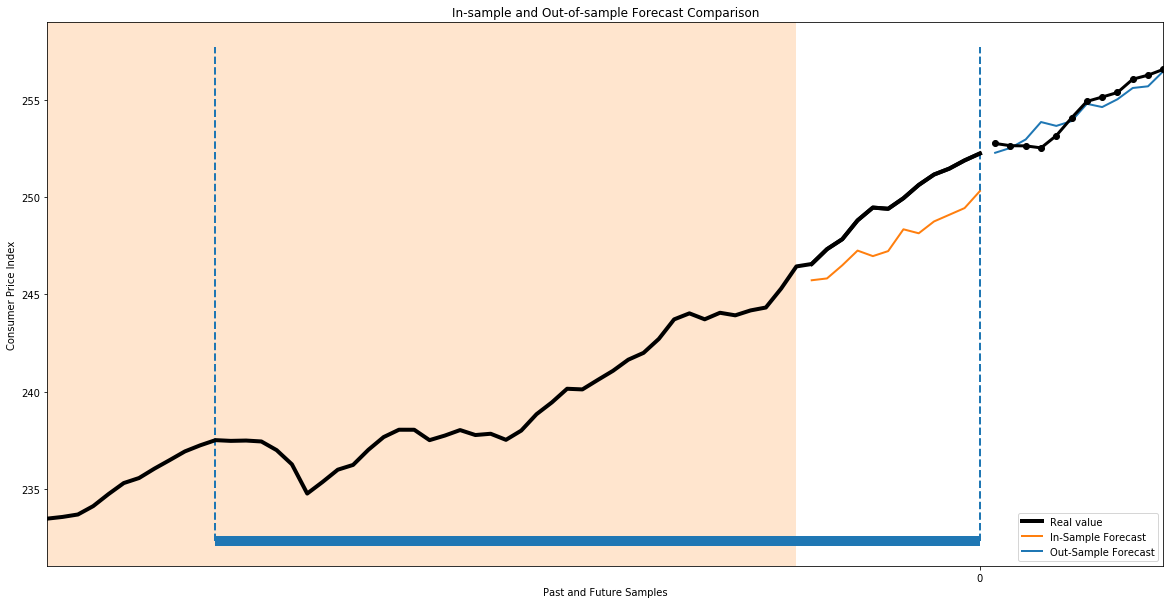

In [15]:
plt.figure(figsize=(20,10))
plt.title('In-sample and Out-of-sample Forecast Comparison') 
plt.plot(1+np.arange(stepsToForecast[-1])-stepsToForecast[-1], df_train.values[-stepsToForecast[-1]:], 'k', linewidth = 4)
plt.plot(1+np.arange(stepsToForecast[-1])-stepsToForecast[-1], list_pred_outlRemoved[0][3], color=cmap(1), linewidth = 2 )
plt.plot(range(1,len(predictions_array)+1), list_pred_outlRemoved[0][2], color=cmap(0), linewidth=2)
plt.legend(['Real value', 'In-Sample Forecast', 'Out-Sample Forecast'])
plt.plot(1+np.arange(stepsToForecast[-1]), df_test.values, 'k-o' , linewidth = 3)
plt.plot(1+np.arange(stepsToForecast[-1]+n_steps_input)-stepsToForecast[-1]-n_steps_input, df_train.values[-n_steps_input-stepsToForecast[-1]:], 'k', linewidth = 4)

plt.xlim([1-stepsToForecast[-1]-n_steps_input,+stepsToForecast[-1]])
plt.xticks([0], '0')

plt.xlabel('Past and Future Samples')
plt.ylabel(ylab)

plt.axvspan(-stepsToForecast[-1]-n_steps_input, -stepsToForecast[-1], facecolor=cmap(1), alpha=0.2)
xmin, xmax, ymin, ymax = plt.axis()
plt.hlines(ymin, -n_steps_input, 0, colors=cmap(0), linewidth=10)
plt.vlines(-n_steps_input, ymin, ymax, colors=cmap(0), linewidth=2, linestyle='--')
plt.vlines(0, ymin, ymax, colors=cmap(0), linewidth=2, linestyle='--')
plt.show()

In [16]:
list_pred_outlRemoved[0][2]

array([252.29704285, 252.54867554, 252.98425293, 253.8809967 ,
       253.68164062, 253.93043518, 254.81941223, 254.65216064,
       255.05419922, 255.63447571, 255.72070312, 256.49676514])